In [1]:
import numpy as np
import xarray as xr
import netCDF4
import os
import datetime
import matplotlib.pyplot as plt 
from matplotlib import cm
import shutil
from datetime import datetime, timedelta
import glob
import datetime as dt
from os import path
import os
import cartopy.crs as ccrs
import fsspec
import git 
import json
import sys
import yaml
import requests
import cdsapi
from datetime import timezone
from functions_verification import *
from functions_rf import *


Using TensorFlow backend.


In [2]:
# change yaml location here
with open(r"/Volumes/lexplore_hd/scripts/folder_gap_filling.yaml", "r") as f:
    directories = yaml.load(f, Loader=yaml.FullLoader)

In [3]:
# change yaml location here
with open(r"/Volumes/lexplore_hd/scripts/boundary_conditions_gap_filling.yaml", "r") as f:
    conditions = yaml.load(f, Loader=yaml.FullLoader)

In [4]:
startyear=2020
today= datetime.today()
endyear=2023

focus_start=conditions["focus_period_start"]
focus_end=conditions["focus_period_end"]

Date: August 2023

Author: Martin Wegmann

Contact: martinwegmann@pm.me



This notebook will download updates of the LéXPLORE Core Data based on the git cloned folders from https://gitlab.renkulab.io/lexplore.

We look at four datasets here:

* The automatic weather station data

* The Temperature Chain data

* The multi-sensor Thetis data

* The multi-sensor Idronaut data

The postprocessing and data reduction includes:

* resampling all limnological data to 3 hourly resolution

* resampling the atmospheric data to 1 hourly resolution

* Selecting certain depths levels

* Selecting certain variables

* Selecting a certain time frame

* Selecting values that are quality flagged as good quality

### Folder Setup

In [5]:
for d in directories.values():
    if not os.path.exists(d):
        os.makedirs(d)

In [6]:
# defining folders
output_folder=directories["g2s_input_folder"]

tchain_folder = directories["tchain_folder"]

thetis_folder = directories["thetis_folder"]

meteo_folder = directories["meteo_folder"]

idronaut_folder = directories["idronaut_folder"]

scripts_folder=directories["scripts_folder"]

era5_folder=directories["era5_folder"]

era5_land_folder=directories["era5_land_folder"]

In [7]:
thetis_folder_data=thetis_folder+"data/Level2/"
meteo_folder_data=meteo_folder+"data/Level1/"
tchain_folder_data=tchain_folder+"data/Level1/"
idronaut_folder_data=idronaut_folder+"data/Level2/"

### Update Lexplore data

In [9]:
os.chdir(tchain_folder)

!python scripts/download_remote_data.py -w

Attempting to sync s3://eawag-data/renkulab.io/lexplore/thermister-chain/data with /Volumes/lexplore_hd/core_data/thermister-chain/data
Download complete.


In [10]:
os.chdir(thetis_folder)

!python scripts/download_remote_data.py -w
!rm /Volumes/lexplore_hd/core_data/thetis-multi-instrument-profiler/data/Level2/L2_THETIS_GRID_20191202_20191212.nc

Traceback (most recent call last):
  File "scripts/download_remote_data.py", line 42, in download_remote_data
    check_output(["aws", "s3", "ls", bucket_uri, "--no-sign-request"])
  File "/Users/mwegmann/miniconda2/envs/temprec/lib/python3.7/subprocess.py", line 411, in check_output
    **kwargs).stdout
  File "/Users/mwegmann/miniconda2/envs/temprec/lib/python3.7/subprocess.py", line 512, in run
    output=stdout, stderr=stderr)
subprocess.CalledProcessError: Command '['aws', 's3', 'ls', 's3://eawag-data/renkulab.io/lexplore/thetis-multi-instrument-profiler/data', '--no-sign-request']' returned non-zero exit status 1.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "scripts/download_remote_data.py", line 78, in <module>
    download_remote_data(warning=args["warning"], delete=args["warning"])
  File "scripts/download_remote_data.py", line 44, in download_remote_data
    raise ValueError("Unable to download, {} does not e

In [11]:
os.chdir(idronaut_folder)

!python scripts/download_remote_data.py -w

Attempting to sync s3://eawag-data/renkulab.io/lexplore/idronaut-automatic-profiler/data with /Volumes/lexplore_hd/core_data/idronaut-automatic-profiler/data
Download complete.


In [12]:
os.chdir(meteo_folder)

!python scripts/download_remote_data.py -w

Attempting to sync s3://eawag-data/renkulab.io/lexplore/meteostation/data with /Volumes/lexplore_hd/core_data/meteostation/data
Download complete.


In [13]:
#g = git.cmd.Git(manctd_folder)
#g.pull()

### Read and Postprocess the AWS data

In [8]:
files = [meteo_folder_data+filename for filename in rm_point(os.listdir(meteo_folder_data))]

In [9]:
meteo_data_raw=xr.open_mfdataset(files)

In [10]:
meteo_data_raw

<xarray.Dataset>
Dimensions:        (time: 206383)
Coordinates:
  * time           (time) datetime64[ns] 2019-07-29T18:00:00 ... 2023-08-07T1...
Data variables: (12/23)
    Batt           (time) float64 dask.array<chunksize=(900,), meta=np.ndarray>
    Ptemp          (time) float64 dask.array<chunksize=(900,), meta=np.ndarray>
    AirTC          (time) float64 dask.array<chunksize=(900,), meta=np.ndarray>
    RH             (time) float64 dask.array<chunksize=(900,), meta=np.ndarray>
    Slrw           (time) float64 dask.array<chunksize=(900,), meta=np.ndarray>
    Slrm           (time) float64 dask.array<chunksize=(900,), meta=np.ndarray>
    ...             ...
    Slrm_qual      (time) float64 dask.array<chunksize=(900,), meta=np.ndarray>
    WS_qual        (time) float64 dask.array<chunksize=(900,), meta=np.ndarray>
    WindDir_qual   (time) float64 dask.array<chunksize=(900,), meta=np.ndarray>
    Rain_qual      (time) float64 dask.array<chunksize=(900,), meta=np.ndarray>
    BP_qual        (time) float64 dask.array<chunksize=(900,), meta=np.ndarray>
    WindGust_qual  (time) float64 dask.array<chunksize=(900,), meta=np.ndarray>
Attributes:
    institution:  EPFL
    source:       Lexplore Weather station Campbell CR1000
    references:   LéXPLORE commun instruments sebastien.lavanchy@epfl.ch
    history:      See history on Renku
    conventions:  CF 1.7
    comment:      Data from the Meteostation on Lexplore Platform in Lake Geneva
    title:        Lexplore Meteostation

In [11]:
file_list=[]
try:
    for year in range(2019,endyear+1):
        writeout_name=output_folder+"meteo_"+str(year)+"_1hr.nc"
        print(year)
        if year>=endyear-1:
            meteo_year=meteo_data_raw.sel(time=slice(str(year)+"-07-01",str(year+1)+"-06-30"))
            meteo_year=meteo_year.load()
            meteo_year.resample(time="1H").mean().to_netcdf(writeout_name)
        if os.path.exists(writeout_name):
            print("Exists already")
        else:
            meteo_year=meteo_data_raw.sel(time=slice(str(year)+"-07-01",str(year+1)+"-06-30"))
            meteo_year=meteo_year.load()
            meteo_year.resample(time="1H").mean().to_netcdf(writeout_name)
        file_list.append(writeout_name)
except:
    print("data not yet available")

2019
Exists already
2020
Exists already
2021
Exists already
2022
Exists already
2023
Exists already


In [12]:
meteo_all_1hr=xr.open_mfdataset(file_list)

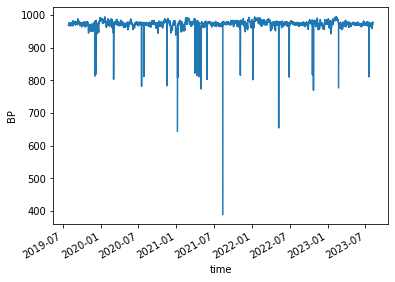

In [19]:
meteo_all_1hr.BP.plot()

In [14]:
meteo_all_1hr=meteo_all_1hr.load()

In [15]:
vars_meteo=['AirTC',
 'RH',
 'Slrw',
 'WS',
 'WindDir',
 'Rain',
 'BP','WindGust']

In [16]:
# dismiss values that dont pass qc
xr_list=[]
for var in vars_meteo:
    xr_list.append(meteo_all_1hr[var].where(meteo_all_1hr[var+"_qual"]==0))
meteo_all_1hr_qualcheck=xr.merge(xr_list)
#meteo_all_1hr_qualcheck=meteo_all_1hr_qualcheck

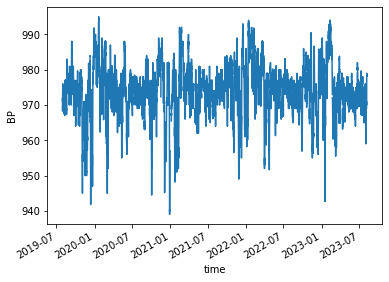

In [18]:
meteo_all_1hr_qualcheck.BP.plot()

In [20]:
meteo_all_1hr_qualcheck[vars_meteo].sel(time=slice(focus_start,focus_end)).to_netcdf(output_folder+"meteo_1hr_g2s.nc")

In [21]:
xr.open_dataset(output_folder+"meteo_1hr_g2s.nc")

<xarray.Dataset>
Dimensions:   (time: 26280)
Coordinates:
  * time      (time) datetime64[ns] 2020-06-01 ... 2023-05-31T23:00:00
Data variables:
    AirTC     (time) float64 ...
    RH        (time) float64 ...
    Slrw      (time) float64 ...
    WS        (time) float64 ...
    WindDir   (time) float64 ...
    Rain      (time) float64 ...
    BP        (time) float64 ...
    WindGust  (time) float64 ...

### Read and Postprocess the Temperature Chain Data

In [23]:

files_L1 = [tchain_folder_data+filename for filename in rm_point(os.listdir(tchain_folder_data))]

In [24]:
tchain_data_raw=xr.open_mfdataset(files_L1,engine="netcdf4")

In [25]:
tchain_data_masked=tchain_data_raw.temp.where(tchain_data_raw.temp_qual==0)

In [26]:
depth_focus=tchain_data_masked.depth.values[1:39]

In [27]:
tchain_data_masked.resample(time="3H").mean().sel(time=slice(focus_start,focus_end)).sel(depth=depth_focus,method="nearest").to_netcdf(output_folder+"tchain_3hr_g2s.nc")

/Users/mwegmann/miniconda2/envs/temprec/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [28]:
xr.open_dataset(output_folder+"tchain_3hr_g2s.nc")

<xarray.Dataset>
Dimensions:  (time: 8760, depth: 38)
Coordinates:
  * time     (time) datetime64[ns] 2020-06-01 ... 2023-05-31T21:00:00
  * depth    (depth) float64 0.5 0.75 1.0 1.25 1.5 ... 39.0 42.0 45.0 48.0 51.0
Data variables:
    temp     (depth, time) float64 ...

### Read and Postprocess the Thetis Data

In [29]:
files_L2 = [thetis_folder_data+filename for filename in rm_point(os.listdir(thetis_folder_data))]

In [30]:
vars=["temp","do","dosat","chla"]
read_file_list=[]
for file in files_L2:
    #print(file)
    file=xr.open_dataset(file)
    file=file[vars]
    read_file_list.append(file)
thetis_data_raw=xr.merge(read_file_list)

In [31]:
thetis_data_raw.resample(time="3H").mean().sel(time=slice(focus_start,focus_end)).sel(depth=depth_focus,method="nearest").to_netcdf(output_folder+"thetis_3hr_g2s.nc")

In [32]:
xr.open_dataset(output_folder+"thetis_3hr_g2s.nc")

<xarray.Dataset>
Dimensions:  (time: 8760, depth: 38)
Coordinates:
  * time     (time) datetime64[ns] 2020-06-01 ... 2023-05-31T21:00:00
  * depth    (depth) float64 1.0 1.0 1.0 1.2 1.5 ... 39.0 42.0 45.0 48.0 50.0
Data variables:
    temp     (time, depth) float64 ...
    do       (time, depth) float64 ...
    dosat    (time, depth) float64 ...
    chla     (time, depth) float64 ...

### Read and Postprocess the Idronaut Data

In [33]:
files_L2 = [idronaut_folder_data+filename for filename in rm_point(os.listdir(idronaut_folder_data))]

In [34]:
vars=["Temp","OPTOppm","OPTO%","Chl","Chl2"]
read_file_list=[]
for file in files_L2:
    #print(file)
    file=xr.open_dataset(file)
    file=file[vars]
    read_file_list.append(file)
idronaut_data_raw=xr.merge(read_file_list)
idronaut_data_raw=idronaut_data_raw.rename({'Chl': 'chla','Chl2': 'chla2','Temp': 'temp','OPTO%': 'dosat','OPTOppm': 'do'})
idronaut_data_raw=idronaut_data_raw.rename({'Press': 'depth'})

In [35]:
idronaut_data_raw.resample(time="3H").mean().sel(time=slice(focus_start,focus_end)).sel(depth=depth_focus,method="nearest").to_netcdf(output_folder+"idronaut_3hr_g2s.nc")

In [36]:
xr.open_dataset(output_folder+"idronaut_3hr_g2s.nc")

<xarray.Dataset>
Dimensions:  (time: 8532, depth: 38)
Coordinates:
  * time     (time) datetime64[ns] 2020-06-29T12:00:00 ... 2023-05-31T21:00:00
  * depth    (depth) float64 0.4 0.8 1.0 1.2 1.4 ... 39.0 42.0 45.0 48.0 51.0
Data variables:
    temp     (time, depth) float64 ...
    do       (time, depth) float64 ...
    dosat    (time, depth) float64 ...
    chla     (time, depth) float64 ...
    chla2    (time, depth) float64 ...

### Read and Postprocess the Manual CTD data

In [37]:
#files_L2 = [manctd_folder_data+filename for filename in rm_point(os.listdir(manctd_folder_data))]

In [38]:
# vars=["Temp","DO_mg","sat","Chl_A"]
# read_file_list=[]
# for file in files_L2:
#     #print(file)
#     file=xr.open_dataset(file)
#     file=file[vars]
#     read_file_list.append(file)
# manctd_data_raw=xr.merge(read_file_list)
# manctd_data_raw=manctd_data_raw.rename({'Chl_A': 'chla','SALIN': 'sal','Temp': 'temp','Cond': 'cond','sat': 'dosat','DO_mg': 'do'})

In [39]:
#manctd_data_raw.resample(time="3H").mean().to_netcdf(output_folder+"manctd_3hr.nc")

In [40]:
#fig, ax = plt.subplots(figsize=(20,10))
#manctd_data_raw.resample(time="3H").mean().temp.plot()